In [6]:
#pip install google-cloud-automl

#### The below code is for productionalising and making this code reproducible.
#### It restarts the kernel once the google-cloud-automl has been installed. Commenting for now

In [4]:
# from IPython.core.display import HTML
# HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [8]:
PROJECT_ID = "ut-goog"
COMPUTE_REGION = "us-central1"

#### Authenticate your GCP account:
If you are using AI Platform Notebooks, your environment is already authenticated. Skip this step.
I'm commenting the code in case this needs to be run from elsewhere.

Otherwise, follow these steps:
1. In the GCP Console, go to the Create service account key page.
2. From the Service account drop-down list, select New service account.
3. In the Service account name field, enter a name.
4. From the Role drop-down list, select AutoML > AutoML Admin and Storage > Storage Object Admin.
5. Click Create. A JSON file that contains your key downloads to your local environment.

Upload the downloaded JSON file that contains your key.

In [ ]:
# import sys

# if 'google.colab' in sys.modules:    
#   from google.colab import files
#   keyfile_upload = files.upload()
#   keyfile = list(keyfile_upload.keys())[0]
#   %env GOOGLE_APPLICATION_CREDENTIALS $keyfile
#   ! gcloud auth activate-service-account --key-file $keyfile

# %env GOOGLE_APPLICATION_CREDENTIALS /path/to/service/account
# ! gcloud auth activate-service-account --key-file '/path/to/service/account'

#### Create a Cloud Storage bucket

When you submit a training job using the Cloud SDK, you upload a Python package containing your training code to a Cloud Storage bucket. 
AI Platform runs the code from this package. 
AI Platform also saves the trained model that results from your job in the same bucket. 
You can then create an AI Platform model version based on this output in order to serve online predictions.

In [11]:
BUCKET_NAME = "cpfb"

Only if your bucket doesn't already exist: Run the following cell to create your Cloud Storage bucket.

In [12]:
! gsutil mb -p $PROJECT_ID -l $COMPUTE_REGION gs://$BUCKET_NAME

Creating gs://cpfb/...


In [13]:
# Validating access to cloud storage bucket by checking its contents
! gsutil ls -al gs://$BUCKET_NAME

#### Import libraries and define constants
Import relevant packages

In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [15]:
# AutoML library.
from google.cloud import automl_v1beta1 as automl
import google.cloud.automl_v1beta1.proto.data_types_pb2 as data_types

In [16]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

In [35]:
# Iniatialising constants
#@title Constants { vertical-output: true }

# A name for the AutoML tables Dataset to create.
DATASET_DISPLAY_NAME = 'rolled_up_data' 
# The BigQuery dataset to import data from (doesn't need to exist).
BQ_DATASET_NAME = "nl_api"
# The BigQuery table to import data from (doesn't need to exist).
BQ_TABLE_NAME = "Karan_rolled_up_data" 
# A name for the AutoML tables model to create.
MODEL_DISPLAY_NAME = 'rolled_up_data_api_model1'

assert all([
    PROJECT_ID,
    COMPUTE_REGION,
    DATASET_DISPLAY_NAME,
    BQ_DATASET_NAME,
    BQ_TABLE_NAME,
    MODEL_DISPLAY_NAME,
])

In [17]:
# Initialize the clients.
automl_client = automl.AutoMlClient()
tables_client = automl.TablesClient(project=PROJECT_ID, region=COMPUTE_REGION)

#### Test the set up
To test whether your project set up and authentication steps were successful, run the following cell to list your datasets in this project.
If no dataset has previously imported into AutoML Tables, you shall expect an empty return.

In [19]:
# List the datasets.
list_datasets = tables_client.list_datasets()
datasets = { dataset.display_name: dataset.name for dataset in list_datasets }
datasets

{'model1': 'projects/320881631258/locations/us-central1/datasets/TBL1404038965274607616',
 'untitled_1583352987864': 'projects/320881631258/locations/us-central1/datasets/TBL3542967313298882560',
 'wrapped_up_labels_model': 'projects/320881631258/locations/us-central1/datasets/TBL6065449297556537344'}

In [20]:
# List the models.
list_models = tables_client.list_models()
models = { model.display_name: model.name for model in list_models }
models

{'model1_20200303015822': 'projects/320881631258/locations/us-central1/models/TBL5681409677183680512',
 'model1_20200303085010': 'projects/320881631258/locations/us-central1/models/TBL8368651279840313344',
 'model1_20200304011142': 'projects/320881631258/locations/us-central1/models/TBL1982547008228950016',
 'model1_20200304011232': 'projects/320881631258/locations/us-central1/models/TBL1441411365502713856',
 'model1_20200304011324': 'projects/320881631258/locations/us-central1/models/TBL3039767020754173952',
 'wrapped_up_labels_20200331111127': 'projects/320881631258/locations/us-central1/models/TBL3708322867000115200',
 'wrapped_up_labels_20200331111224': 'projects/320881631258/locations/us-central1/models/TBL1593882841949667328'}

#### Import training data
##### Create dataset
Now we are ready to create a dataset instance (on GCP) using the client method create_dataset(). This method has one required parameter, the human readable display name DATASET_DISPLAY_NAME.
Select a dataset display name and pass your table source information to create a new dataset.

In [25]:
# Create dataset.
dataset = tables_client.create_dataset(
          dataset_display_name=DATASET_DISPLAY_NAME)
dataset_name = dataset.name
dataset

name: "projects/320881631258/locations/us-central1/datasets/TBL1431843415317807104"
display_name: "rolled_up_data"
create_time {
  seconds: 1586361447
  nanos: 754664000
}
etag: "AB3BwFqXJs46B-rFUb6uJPBpgoWPbhFRh9KngHFY1vo4vI1IGYgUgm1ZhIAEZg44hPWY"
tables_dataset_metadata {
  stats_update_time {
  }
}

##### Import data

In [26]:
dataset_bq_input_uri = 'bq://{0}.{1}.{2}'.format(
    PROJECT_ID, BQ_DATASET_NAME, BQ_TABLE_NAME)

import_data_response = tables_client.import_data(
    dataset=dataset, bigquery_input_uri=dataset_bq_input_uri)

print('Dataset import operation: {}'.format(import_data_response.operation))

# Synchronous check of operation status. Wait until import is done.
print('Dataset import response: {}'.format(import_data_response.result()))

# Verify the status by checking the example_count field.
dataset = tables_client.get_dataset(dataset_name=dataset_name)
dataset

Dataset import operation: name: "projects/320881631258/locations/us-central1/operations/TBL8688788383918456832"
metadata {
  type_url: "type.googleapis.com/google.cloud.automl.v1beta1.OperationMetadata"
  value: "\032\014\010\375\350\267\364\005\020\350\335\270\277\002\"\014\010\375\350\267\364\005\020\350\335\270\277\002z\000"
}

Dataset import response: 


name: "projects/320881631258/locations/us-central1/datasets/TBL1431843415317807104"
display_name: "rolled_up_data"
create_time {
  seconds: 1586361447
  nanos: 754664000
}
etag: "AB3BwFosfTummg7I2vXrLUpwnKRU6gbXkveA46mY8SHZJqYCpKZl7nfzCAt52E1lU_9Q"
example_count: 496718
tables_dataset_metadata {
  primary_table_spec_id: "1401244006716801024"
  stats_update_time {
    seconds: 1586361654
    nanos: 933000000
  }
}

#### Review table specs to verify valdity of data import

In [27]:
# List table specs.
list_table_specs_response = tables_client.list_table_specs(dataset=dataset)
table_specs = [s for s in list_table_specs_response]

# List column specs.
list_column_specs_response = tables_client.list_column_specs(dataset=dataset)
column_specs = {s.display_name: s for s in list_column_specs_response}

# Print Features and data_type.
features = [(key, data_types.TypeCode.Name(value.data_type.type_code)) 
            for key, value in column_specs.items()]
print('Feature list:\n')
for feature in features:
    print(feature[0],':', feature[1])

Feature list:

consumer_complaint_narrative : STRING
timely_response : CATEGORY
entity_sentiment_scores : STRING
entity_types : STRING
consumer_consent_provided : CATEGORY
product : STRING
tags : CATEGORY
company_public_response : CATEGORY
subproduct : STRING
consumer_disputed : CATEGORY
entity_sentiment_magnitudes : STRING
entities : STRING
date_sent_to_company : TIMESTAMP
company_response_to_consumer : CATEGORY
issue : STRING
state : CATEGORY
company_name : STRING
subissue : STRING
date_received : TIMESTAMP
submitted_via : CATEGORY
complaint_id : FLOAT64
sentiment_score : FLOAT64
sentiment_magnitude : FLOAT64
zip_code : CATEGORY


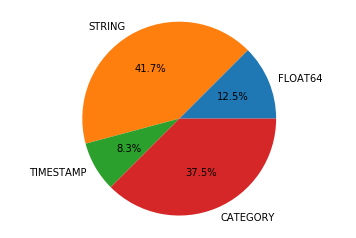

In [28]:
# Table schema pie chart.
type_counts = {}
for column_spec in column_specs.values():
  type_name = data_types.TypeCode.Name(column_spec.data_type.type_code)
  type_counts[type_name] = type_counts.get(type_name, 0) + 1
    
plt.pie(x=type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [31]:
# Target column cannot be nullable. This code sets it as non nullable
column_spec_display_name = 'company_response_to_consumer'

update_column_response = tables_client.update_column_spec(
    dataset=dataset,
    column_spec_display_name=column_spec_display_name,
    nullable=False,
)
update_column_response

name: "projects/320881631258/locations/us-central1/datasets/TBL1431843415317807104/tableSpecs/1401244006716801024/columnSpecs/8771426578350473216"
data_type {
  type_code: CATEGORY
}
display_name: "company_response_to_consumer"
data_stats {
  distinct_value_count: 5
  null_value_count: 1
  category_stats {
    top_category_stats {
      value: "Closed with explanation"
      count: 401455
    }
    top_category_stats {
      value: "Closed with non-monetary relief"
      count: 61784
    }
    top_category_stats {
      value: "Closed with monetary relief"
      count: 26595
    }
    top_category_stats {
      value: "Closed"
      count: 3741
    }
    top_category_stats {
      value: "Untimely response"
      count: 3142
    }
  }
  valid_value_count: 496718
}
etag: "AB3BwFpaa3u2J61cWwJ9qTYy4KqxhjO0Pda7DEwZUUTd8jmQeOy33Ehv3BgqmTQ_tC1w"

In [32]:
# Assign a target variable
column_spec_display_name = 'company_response_to_consumer' 
update_dataset_response = tables_client.set_target_column(
    dataset=dataset,
    column_spec_display_name=column_spec_display_name,
)
update_dataset_response

name: "projects/320881631258/locations/us-central1/datasets/TBL1431843415317807104"
display_name: "rolled_up_data"
create_time {
  seconds: 1586361447
  nanos: 754664000
}
etag: "AB3BwFr8VHyRgajRDc-sHDW0t70knAcH2w4AuFgd10v8t-BaNyKCu00ACncjgs5ff5kX"
example_count: 496718
tables_dataset_metadata {
  primary_table_spec_id: "1401244006716801024"
  target_column_spec_id: "8771426578350473216"
  stats_update_time {
    seconds: 1586361654
    nanos: 933000000
  }
}

#### Create a Model

In [36]:
# The number of hours to train the model.
model_train_hours = 1 #@param {type:'integer'}

create_model_response = tables_client.create_model(
    model_display_name=MODEL_DISPLAY_NAME,
    dataset=dataset,
    train_budget_milli_node_hours=model_train_hours*1000,
    exclude_column_spec_names=['company_response_to_consumer','timely_response','entity_sentiment_scores',
                               'entity_types','consumer_consent_provided','company_public_response',
                               'consumer_disputed','entity_sentiment_magnitudes','entities','date_sent_to_company',
                               'company_response_to_consumer','date_received','submitted_via','complaint_id',
                               'sentiment_score', 'sentiment_magnitude'],
)

operation_id = create_model_response.operation.name

print('Create model operation: {}'.format(create_model_response.operation))

Create model operation: name: "projects/320881631258/locations/us-central1/operations/TBL6548452661010628608"
metadata {
  type_url: "type.googleapis.com/google.cloud.automl.v1beta1.OperationMetadata"
  value: "\032\014\010\327\364\267\364\005\020\260\312\370\305\002\"\014\010\327\364\267\364\005\020\260\312\370\305\002R\000"
}



In [ ]:
# Wait until model training is done.
model = create_model_response.result()
model_name = model.name
model